In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power, quad_distribute_power, propagation_delay, gen_qrx_onlyclocked

from parametermeasurement import generate_clocks, measure_range_roberts, measure_bearing

from positioning import classicalfix_directbearing_mle, classicalfix_diffbearing_mle, \
                        classicalfix_directrange_mle, classicalfix_diffrange_mle, \
                        runningfix_directbearing_mle, runningfix_directrange_mle

from simulation import Simulation, generate_simulation_clocks

### Set common simulation configurations

In [2]:
iterations = 1000

### world parameters
sim = Simulation(weather        = "clear", 
                 temperature    = 298,   # [K], circuit temperature
                 daynight       = "day_indirectsun", 
                 rxconfig       = "optics/qrx_planoconvex.npz", 
                 txconfig       = "optics/tx_lambertian_20deg_2W.npz", 
                 istxlambertian = True, 
                 f_adc_clk      = 1.0e7,  # [Hz] ADC measurement clock freq
                 f_e            = 1.0e6,  # [Hz] emitted wave freq, left TX
                 f_sim          = 1.0e10) # [Hz] simulation master clock freq

L_ego    = 1.6 # [m]
L_target = 1.5 # [m] arbitrary selection, just to make it different than the ego. This is not known, so it's not used in the algo

### build lane change trajectory similar to the PIMRC article
# starts with constant heading, sliding, then starts to level out with changing heading (a curved portion at the end on xy plane)
a = np.load('trajectories/generated_platooning.npz')

# vehicle timing in simulations are sampled at 1kHz
trj_numsamples_slow2  = 4000 # will correspond to 4s
trj_numsamples_slow1  = 2000 # will correspond to 2s
trj_numsamples_normal = 1000 # will correspond to 1s
trj_numsamples_fast1  = 500 # will correspond to 0.5s
trj_numsamples_fast2  = 250 # will correspond to 0.25s

# simulation timing parameters, generate simulation clocks
# define a special "vehicle clock" to follow the trajectory
f_vehicle = 1e3;         # [Hz], trajectory simulation clock rate, fixed by trajectory generation
t_vehicle = 1/f_vehicle; # [s] , trajectory simulation clock period, fixed by trajectory generation

t_sim_stop_slow2 = t_vehicle*trj_numsamples_slow2
s_veh_clock_slow2 = generate_simulation_clocks(t_sim_stop_slow2, sim.f_simulation, f_vehicle, gen_clocked_only=True)
t_sim_stop_slow1 = t_vehicle*trj_numsamples_slow1
s_veh_clock_slow1 = generate_simulation_clocks(t_sim_stop_slow1, sim.f_simulation, f_vehicle, gen_clocked_only=True)
t_sim_stop_normal = t_vehicle*trj_numsamples_normal
s_veh_clock_normal = generate_simulation_clocks(t_sim_stop_normal, sim.f_simulation, f_vehicle, gen_clocked_only=True)
t_sim_stop_fast1 = t_vehicle*trj_numsamples_fast1
s_veh_clock_fast1 = generate_simulation_clocks(t_sim_stop_fast1, sim.f_simulation, f_vehicle, gen_clocked_only=True)
t_sim_stop_fast2 = t_vehicle*trj_numsamples_fast2
s_veh_clock_fast2 = generate_simulation_clocks(t_sim_stop_fast2, sim.f_simulation, f_vehicle, gen_clocked_only=True)

localization_decimation_rate = 10 # to get VLP rate = 100 Hz
localization_rate = 1/(t_vehicle*localization_decimation_rate)
localization_num_steps_slow2 = int(trj_numsamples_slow2/localization_decimation_rate)
localization_num_steps_slow1 = int(trj_numsamples_slow1/localization_decimation_rate)
localization_num_steps_normal = int(trj_numsamples_normal/localization_decimation_rate)
localization_num_steps_fast1 = int(trj_numsamples_fast1/localization_decimation_rate)
localization_num_steps_fast2 = int(trj_numsamples_fast2/localization_decimation_rate)

s_adc_clock_slow2 = generate_simulation_clocks(t_sim_stop_slow2, sim.f_simulation, sim.f_adc_clock, gen_clocked_only=True)
s_adc_clock_slow1 = generate_simulation_clocks(t_sim_stop_slow1, sim.f_simulation, sim.f_adc_clock, gen_clocked_only=True)
s_adc_clock_normal = generate_simulation_clocks(t_sim_stop_normal, sim.f_simulation, sim.f_adc_clock, gen_clocked_only=True)
s_adc_clock_fast1 = generate_simulation_clocks(t_sim_stop_fast1, sim.f_simulation, sim.f_adc_clock, gen_clocked_only=True)
s_adc_clock_fast2 = generate_simulation_clocks(t_sim_stop_fast2, sim.f_simulation, sim.f_adc_clock, gen_clocked_only=True)

# sample in normal rate
xRL_to_rxL_normal = a['x_RL'][0:trj_numsamples_normal]; yRL_to_rxL_normal = a['y_RL'][0:trj_numsamples_normal]; 
xRR_to_rxL_normal = a['x_RR'][0:trj_numsamples_normal]; yRR_to_rxL_normal = a['y_RR'][0:trj_numsamples_normal]
yRL_to_rxR_normal = a['y_RL'][0:trj_numsamples_normal]; yRR_to_rxR_normal = a['y_RR'][0:trj_numsamples_normal]; 
hdg_normal  = a['hdg'][0:trj_numsamples_normal];
xRL_to_rxR_normal = a['x_RL'][0:trj_numsamples_normal] - L_ego;
xRR_to_rxR_normal = a['x_RR'][0:trj_numsamples_normal] - L_ego;

# build 4 more versions of the same trajectory: 2 slower 2 faster, basically same trajectory interpolated to different time spans
tslow2 = np.linspace(0,t_sim_stop_slow2,  trj_numsamples_slow2)
tslow1 = np.linspace(0,t_sim_stop_slow1,  trj_numsamples_slow1)
tnormal= np.linspace(0,t_sim_stop_normal, trj_numsamples_normal)
tfast1 = np.linspace(0,t_sim_stop_fast1,  trj_numsamples_fast1)
tfast2 = np.linspace(0,t_sim_stop_fast2,  trj_numsamples_fast2)

def time_interp(tnew):
    multiplier = len(tnew)/len(tnormal)
    xRL_to_rxL_n = np.interp(tnew, tnormal*multiplier, xRL_to_rxL_normal)
    yRL_to_rxL_n = np.interp(tnew, tnormal*multiplier, yRL_to_rxL_normal)
    xRL_to_rxR_n = np.interp(tnew, tnormal*multiplier, xRL_to_rxR_normal)
    yRL_to_rxR_n = np.interp(tnew, tnormal*multiplier, yRL_to_rxR_normal)
    xRR_to_rxL_n = np.interp(tnew, tnormal*multiplier, xRR_to_rxL_normal)
    yRR_to_rxL_n = np.interp(tnew, tnormal*multiplier, yRR_to_rxL_normal)
    xRR_to_rxR_n = np.interp(tnew, tnormal*multiplier, xRR_to_rxR_normal)
    yRR_to_rxR_n = np.interp(tnew, tnormal*multiplier, yRR_to_rxR_normal)
    hdg_n = np.interp(tnew, tnormal*multiplier, hdg_normal)
    return xRL_to_rxL_n, yRL_to_rxL_n, xRL_to_rxR_n, yRL_to_rxR_n, xRR_to_rxL_n, yRR_to_rxL_n, xRR_to_rxR_n, yRR_to_rxR_n, hdg_n

xRL_to_rxL_slow1, yRL_to_rxL_slow1, xRL_to_rxR_slow1, yRL_to_rxR_slow1, \
xRR_to_rxL_slow1, yRR_to_rxL_slow1, xRR_to_rxR_slow1, yRR_to_rxR_slow1, hdg_slow1 = time_interp(tslow1)
xRL_to_rxL_slow2, yRL_to_rxL_slow2, xRL_to_rxR_slow2, yRL_to_rxR_slow2, \
xRR_to_rxL_slow2, yRR_to_rxL_slow2, xRR_to_rxR_slow2, yRR_to_rxR_slow2, hdg_slow2 = time_interp(tslow2)
xRL_to_rxL_fast1, yRL_to_rxL_fast1, xRL_to_rxR_fast1, yRL_to_rxR_fast1, \
xRR_to_rxL_fast1, yRR_to_rxL_fast1, xRR_to_rxR_fast1, yRR_to_rxR_fast1, hdg_fast1 = time_interp(tfast1)
xRL_to_rxL_fast2, yRL_to_rxL_fast2, xRL_to_rxR_fast2, yRL_to_rxR_fast2, \
xRR_to_rxL_fast2, yRR_to_rxL_fast2, xRR_to_rxR_fast2, yRR_to_rxR_fast2, hdg_fast2 = time_interp(tfast2)

### Define full simulation run as a function

In [3]:
def simrun(xRL_to_rxL, yRL_to_rxL, xRL_to_rxR, yRL_to_rxR, 
           xRR_to_rxL, yRR_to_rxL, xRR_to_rxR, yRR_to_rxR, hdg,
           s_veh_clock, s_adc_clock, sim, localization_num_steps, iterations):
    ### simulate received power
    pwr_txL_to_rxL = received_power(xRL_to_rxL, yRL_to_rxL, np.zeros_like(yRL_to_rxL), hdg, sim)
    pwr_txL_to_rxR = received_power(xRL_to_rxR, yRL_to_rxR, np.zeros_like(yRL_to_rxR), hdg, sim)
    pwr_txR_to_rxL = received_power(xRR_to_rxL, yRR_to_rxL, np.zeros_like(yRR_to_rxL), hdg, sim)
    pwr_txR_to_rxR = received_power(xRR_to_rxR, yRR_to_rxR, np.zeros_like(yRR_to_rxR), hdg, sim)
    
    shared_pwr_txL_to_rxL = quad_distribute_power(xRL_to_rxL, yRL_to_rxL, 0, sim.rx_config_bundle["f_QRX"], pwr_txL_to_rxL)
    shared_pwr_txL_to_rxR = quad_distribute_power(xRL_to_rxR, yRL_to_rxR, 0, sim.rx_config_bundle["f_QRX"], pwr_txL_to_rxR)
    shared_pwr_txR_to_rxL = quad_distribute_power(xRR_to_rxL, yRR_to_rxL, 0, sim.rx_config_bundle["f_QRX"], pwr_txR_to_rxL)
    shared_pwr_txR_to_rxR = quad_distribute_power(xRR_to_rxR, yRR_to_rxR, 0, sim.rx_config_bundle["f_QRX"], pwr_txR_to_rxR)
    
    delay_txL_to_rxL = propagation_delay(xRL_to_rxL, yRL_to_rxL, sim.lightspeed)
    delay_txL_to_rxR = propagation_delay(xRL_to_rxR, yRL_to_rxR, sim.lightspeed)
    delay_txR_to_rxL = propagation_delay(xRR_to_rxL, yRR_to_rxL, sim.lightspeed)
    delay_txR_to_rxR = propagation_delay(xRR_to_rxR, yRR_to_rxR, sim.lightspeed)
    
    ### run simulation over the list of points
    aoa_rxL_txL     = np.zeros((localization_num_steps)); aoa_rxR_txL     = np.zeros((localization_num_steps))
    aoa_rxL_txR     = np.zeros((localization_num_steps)); aoa_rxR_txR     = np.zeros((localization_num_steps))
    d_rxL_txL       = np.zeros((localization_num_steps)); d_rxR_txL       = np.zeros((localization_num_steps))
    d_rxL_txR       = np.zeros((localization_num_steps)); d_rxR_txR       = np.zeros((localization_num_steps))
    
    cls_x_directbearing     = np.zeros((localization_num_steps, iterations)); 
    cls_y_directrange       = np.zeros((localization_num_steps, iterations));
    
    for j in tqdm(range(0,iterations)):
        for i in range(0, localization_num_steps):
            smp_lo = i*localization_decimation_rate
            smp_hi = (i+1)*localization_decimation_rate
    
            step_time       = s_veh_clock[smp_lo:smp_hi]
            simulation_time = s_adc_clock[int(i*sim.f_adc_clock/f_vehicle):int((i+1)*sim.f_adc_clock/f_vehicle)]
    
            rxLL, rxLR, rxRL, rxRR, delays = gen_qrx_onlyclocked(shared_pwr_txL_to_rxL, shared_pwr_txL_to_rxR, 
                                                                 shared_pwr_txR_to_rxL, shared_pwr_txR_to_rxR,
                                                                 delay_txL_to_rxL, delay_txL_to_rxR, 
                                                                 delay_txR_to_rxL, delay_txR_to_rxR, sim, step_time, 
                                                                 simulation_time, smp_lo, smp_hi);
            (rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL) = rxLL
            (rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR) = rxLR
            (rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL) = rxRL
            (rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR) = rxRR 
            (delayLL_sigTime, delayLR_sigTime, delayRL_sigTime, delayRR_sigTime) = delays
    
            del rxLL, rxLR, rxRL, rxRR, delays 
    
            # initial transmitted signal is known (mark the +, that's because the signal does a roundtrip
            # which is 1 delay earlier than echo transmission from target vehicle)
            wav_rxL_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time + delayLL_sigTime))
            wav_rxR_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time + delayLR_sigTime))
    
            d_rxL_txL[i] = measure_range_roberts(rxLA_txL + rxLB_txL + rxLC_txL + rxLD_txL, wav_rxL_txL, sim.lightspeed, sim.f_emitted)
            d_rxR_txL[i] = measure_range_roberts(rxRA_txL + rxRB_txL + rxRC_txL + rxRD_txL, wav_rxR_txL, sim.lightspeed, sim.f_emitted)
    
            thd = 1e-5; # just to avoid messing up the graphs when aoa detection is too bad.
            # assume that the VLC subsystem correctly decodes the signal (mark that the delayed signal 
            # is decoded, so the delay isn't actually measured, it's implicitly present on the RX signal)
            wav_rxL_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time - delayLL_sigTime))
            wav_rxR_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time - delayLR_sigTime))
            aoa_rxL_txL[i] = measure_bearing(rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL, wav_rxL_txL, sim.rx_config_bundle["f_QRX"], thd)
            aoa_rxR_txL[i] = measure_bearing(rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL, wav_rxR_txL, sim.rx_config_bundle["f_QRX"], thd)
    
            cls_x_directbearing[i,j], _ = classicalfix_directbearing_mle(aoa_rxL_txL[i], aoa_rxR_txL[i], L_ego)
            _, cls_y_directrange[i,j]   = classicalfix_directrange_mle(d_rxL_txL[i], d_rxR_txL[i], L_ego)

    return cls_x_directbearing, cls_y_directrange

### Run simulation for different speeds

In [4]:
est_x_slow2, est_y_slow2 = simrun(xRL_to_rxL_slow2, yRL_to_rxL_slow2, xRL_to_rxR_slow2, yRL_to_rxR_slow2, 
                                  xRR_to_rxL_slow2, yRR_to_rxL_slow2, xRR_to_rxR_slow2, yRR_to_rxR_slow2, hdg_slow2,
                                  s_veh_clock_slow2, s_adc_clock_slow2, sim, localization_num_steps_slow2, iterations);
est_x_slow1, est_y_slow1 = simrun(xRL_to_rxL_slow1, yRL_to_rxL_slow1, xRL_to_rxR_slow1, yRL_to_rxR_slow1, 
                                  xRR_to_rxL_slow1, yRR_to_rxL_slow1, xRR_to_rxR_slow1, yRR_to_rxR_slow1, hdg_slow1,
                                  s_veh_clock_slow1, s_adc_clock_slow1, sim, localization_num_steps_slow1, iterations);
est_x_normal, est_y_normal = simrun(xRL_to_rxL_normal, yRL_to_rxL_normal, xRL_to_rxR_normal, yRL_to_rxR_normal, 
                                    xRR_to_rxL_normal, yRR_to_rxL_normal, xRR_to_rxR_normal, yRR_to_rxR_normal, hdg_normal,
                                    s_veh_clock_normal, s_adc_clock_normal, sim, localization_num_steps_normal, iterations);
est_x_fast1, est_y_fast1 = simrun(xRL_to_rxL_fast1, yRL_to_rxL_fast1, xRL_to_rxR_fast1, yRL_to_rxR_fast1, 
                                  xRR_to_rxL_fast1, yRR_to_rxL_fast1, xRR_to_rxR_fast1, yRR_to_rxR_fast1, hdg_fast1,
                                  s_veh_clock_fast1, s_adc_clock_fast1, sim, localization_num_steps_fast1, iterations);
est_x_fast2, est_y_fast2 = simrun(xRL_to_rxL_fast2, yRL_to_rxL_fast2, xRL_to_rxR_fast2, yRL_to_rxR_fast2, 
                                  xRR_to_rxL_fast2, yRR_to_rxL_fast2, xRR_to_rxR_fast2, yRR_to_rxR_fast2, hdg_fast2,
                                  s_veh_clock_fast2, s_adc_clock_fast2, sim, localization_num_steps_fast2, iterations);

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/ubuntu/vehicular-vlp-simulations/positioning.py:108: RuntimeWarning: invalid value encountered in sqrt
  est_y = np.sqrt(dL**2-est_x**2)
/home/ubuntu/vehicular-vlp-simulations/positioning.py:102: RuntimeWarning: invalid value encountered in scalar divide
  est_x = L*(1 + np.sin(np.deg2rad(aoaR))*np.cos(np.deg2rad(aoaL))/np.sin(np.deg2rad(aoaL - aoaR)));
/home/ubuntu/vehicular-vlp-simulations/positioning.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  est_y = L*np.cos(np.deg2rad(aoaR))*np.cos(np.deg2rad(aoaL))/np.sin(np.deg2rad(aoaL - aoaR));
100%|███████████████████████████████████████| 1000/1000 [01:53<00:00,  8.83it/s]


In [6]:
e_x_slow1 = np.zeros((localization_num_steps_slow1, iterations))
e_y_slow1 = np.zeros((localization_num_steps_slow1, iterations))
e_x_slow2 = np.zeros((localization_num_steps_slow2, iterations))
e_y_slow2 = np.zeros((localization_num_steps_slow2, iterations))
e_x_normal = np.zeros((localization_num_steps_normal, iterations))
e_y_normal = np.zeros((localization_num_steps_normal, iterations))
e_x_fast1 = np.zeros((localization_num_steps_fast1, iterations))
e_y_fast1 = np.zeros((localization_num_steps_fast1, iterations))
e_x_fast2 = np.zeros((localization_num_steps_fast2, iterations))
e_y_fast2 = np.zeros((localization_num_steps_fast2, iterations))
for k in range(0,iterations):
    e_x_slow1[:,k] = xRL_to_rxL_slow1[int(localization_decimation_rate/2)::localization_decimation_rate] - est_x_slow1[:,k]
    e_y_slow1[:,k] = yRL_to_rxL_slow1[int(localization_decimation_rate/2)::localization_decimation_rate] - est_y_slow1[:,k]
    e_x_slow2[:,k] = xRL_to_rxL_slow2[int(localization_decimation_rate/2)::localization_decimation_rate] - est_x_slow2[:,k]
    e_y_slow2[:,k] = yRL_to_rxL_slow2[int(localization_decimation_rate/2)::localization_decimation_rate] - est_y_slow2[:,k]
    e_x_normal[:,k] = xRL_to_rxL_normal[int(localization_decimation_rate/2)::localization_decimation_rate] - est_x_normal[:,k]
    e_y_normal[:,k] = yRL_to_rxL_normal[int(localization_decimation_rate/2)::localization_decimation_rate] - est_y_normal[:,k]
    e_x_fast1[:,k] = xRL_to_rxL_fast1[int(localization_decimation_rate/2)::localization_decimation_rate] - est_x_fast1[:,k]
    e_y_fast1[:,k] = yRL_to_rxL_fast1[int(localization_decimation_rate/2)::localization_decimation_rate] - est_y_fast1[:,k]
    e_x_fast2[:,k] = xRL_to_rxL_fast2[int(localization_decimation_rate/2)::localization_decimation_rate] - est_x_fast2[:,k]
    e_y_fast2[:,k] = yRL_to_rxL_fast2[int(localization_decimation_rate/2)::localization_decimation_rate] - est_y_fast2[:,k]

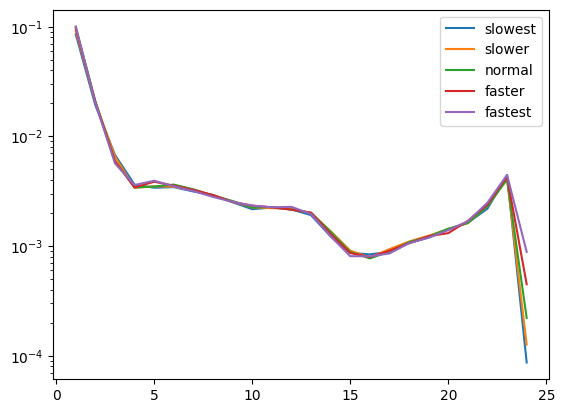

In [7]:
plt.semilogy(np.std(np.sqrt(e_x_slow2[::16]**2 + e_y_slow2[::16]**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_x_slow1[::8]**2 + e_y_slow1[::8]**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_x_normal[::4]**2 + e_y_normal[::4]**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_x_fast1[::2]**2 + e_y_fast1[::2]**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_x_fast2**2 + e_y_fast2**2),axis=-1))
plt.legend(["slowest", "slower", "normal", "faster", "fastest"])

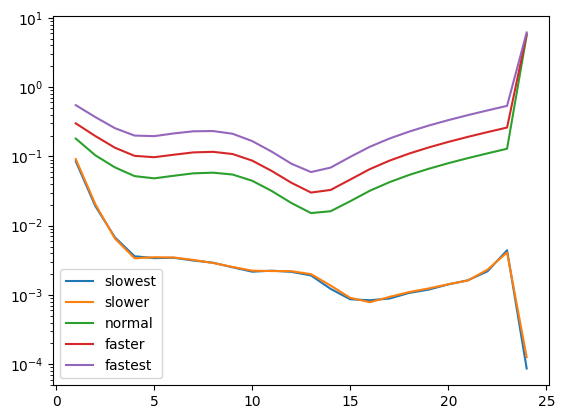

In [9]:
plt.semilogy(np.std(np.sqrt(e_x_slow2[::16]**2 + e_y_slow2[::16]**2),axis=-1))
plt.semilogy(np.std(np.sqrt(e_x_slow1[::8]**2 + e_y_slow1[::8]**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_x_normal[::4]**2 + e_y_normal[::4]**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_x_fast1[::2]**2 + e_y_fast1[::2]**2),axis=-1))
plt.semilogy(np.mean(np.sqrt(e_x_fast2**2 + e_y_fast2**2),axis=-1))
plt.legend(["slowest", "slower", "normal", "faster", "fastest"])